In [1]:
%matplotlib inline
import numpy as np

import seaborn as sns
import pandas as pd
import rubisco_data

from matplotlib import pyplot as plt


In [2]:
# Load BRENDA data
brenda_DF = pd.read_csv('../data/DatasetS3_BRENDA_Kinetics.csv', encoding = "ISO-8859-1")
brenda_DF.head(3)

has_kcat = brenda_DF[brenda_DF.kcat.notnull()]
brenda_by_EC = has_kcat.groupby('EC_number')

# median reported kcat
brenda_kcats = brenda_DF.groupby(['EC_number', 'Organism'], as_index=False).median()
# number of measurements
orths = brenda_kcats.groupby('EC_number', as_index=False).size()
orths = pd.DataFrame(orths).reset_index()
orths.columns = ['EC_number', 'n_orthologs']

var_df = brenda_kcats.groupby('EC_number')['kcat'].apply(lambda x: np.exp(np.log(x).std()))
var_df = pd.DataFrame(var_df).reset_index()
var_df = var_df.merge(orths)

var_df.columns = ['EC', 'mult_var', 'n_orthologs']
var_df.sort_values('n_orthologs', inplace=True, ascending=False)
var_df.set_index('EC', inplace=True)
var_df.dropna(inplace=True)

# Remove low counts, drop rubisco
filtered_var = var_df[var_df.n_orthologs > 5].copy()
filtered_var = filtered_var.drop('4.1.1.39')

filtered_var.head()

,mult_var,n_orthologs
EC,,
3.1.3.2,13.076175,47
1.1.1.37,86.697562,46
2.5.1.18,9.507094,46
4.2.1.1,20.917379,45
4.1.2.13,6.993951,44


In [3]:
# Load the data from Excel, remove data points that are not comparable.
# raw_kin_df is everything in the file, kin_df is the subset with all relevant kinetic data.
raw_kin_df, kin_df = rubisco_data.load_rubisco_data()

# Subset the data in various ways for future use
raw_kin_df, savir_df, nonsavir_df = rubisco_data.filter_data(raw_kin_df)

# Group by RuBisCO form
grouped_form = raw_kin_df.groupby('isoform')

# Markers we use for plotting below.
markers = 'o><^dsphH*'

cnames = ["windows blue", "amber", "greyish brown", "dusty purple", "dusty teal", "dusty red", ]
named_colors = sns.xkcd_palette(cnames)
raw_kin_df.head()

,species,identifier,primary,mutant,heterologous_expression,KC,KC_SD,vC,vC_SD,S,...,KRuBP,KRuBP_SD,temp_C,pH,isoform,taxonomy,note,short_ref,pmid_or_doi,citation
0,Methanococcoides burtonii,burtonii_coli_alonso,1,0,E. coli,130.0,4.0,2.0,0.10,1.18,...,0.13,0.02,25,7,2_3,Archaea,NaN,Alonso 2009,19837658,"Alonso, Hernán, Michelle J. Blayney, Jennifer ..."
1,Spinacia oleracea,oleracea_andrews1985,1,0,False,NaN,NaN,NaN,NaN,105.00,...,NaN,NaN,25,8.52,1,C3 plants,Figure 3,Andrews 1985,3921534,"Andrews TJ, Lorimer GH (1985) Catalytic proper..."
2,Rhodospirillum rubrum,rubrum_andrews1985,1,0,E. coli,NaN,NaN,NaN,NaN,14.00,...,NaN,NaN,25,8.52,2,Alphaproteobacteria,Figure 3,Andrews 1985,3921534,"Andrews TJ, Lorimer GH (1985) Catalytic proper..."
5,Anabena variabilis,variabilis_badger,1,0,False,293.0,27.0,NaN,NaN,NaN,...,21.40,1.30,25,8,1,Cyanobacteria,Anabenas have ccmM,Badger 1980,6772105,"Badger, M. R. (1980). Kinetic properties of ri..."
33,Anacystis nidulans,nidulans_bainbridge,1,0,Unclear,NaN,NaN,7.2,0.15,46.30,...,NaN,NaN,25,8,1,Cyanobacteria,"Methods not clear from paper, assumed pH 8 and...",Bainbridge 1995,https://doi.org/10.1093/jxb/46.special_issue.1272,"Bainbridge, G. et al. Engineering Rubisco to c..."


In [4]:
rub_has_kcat = raw_kin_df[raw_kin_df.vC.notnull()]
rub_grouped = rub_has_kcat.groupby(['species', 'isoform'], as_index=False)
rub_n_orths = rub_grouped.ngroups
rub_median = rub_grouped.median()

rub_mult_var = np.exp(np.std(np.log(rub_median['vC'])))

In [5]:
var_df.at['4.1.1.39', 'n_orthologs'] = rub_n_orths
var_df.at['4.1.1.39', 'mult_var'] = rub_mult_var
var_df.sort_values('n_orthologs', inplace=True, ascending=False)
var_df.head()

,mult_var,n_orthologs
EC,,
4.1.1.39,1.529829,248
3.1.3.2,13.076175,47
1.1.1.37,86.697562,46
2.5.1.18,9.507094,46
4.2.1.1,20.917379,45


In [6]:
top_counts = var_df.iloc[:25].sort_values('mult_var', ascending=True)
brenda_kcats_subset = brenda_kcats[brenda_kcats.EC_number.isin(top_counts.index)].copy()
brenda_kcats_subset = brenda_kcats_subset[brenda_kcats_subset.kcat.notnull()]

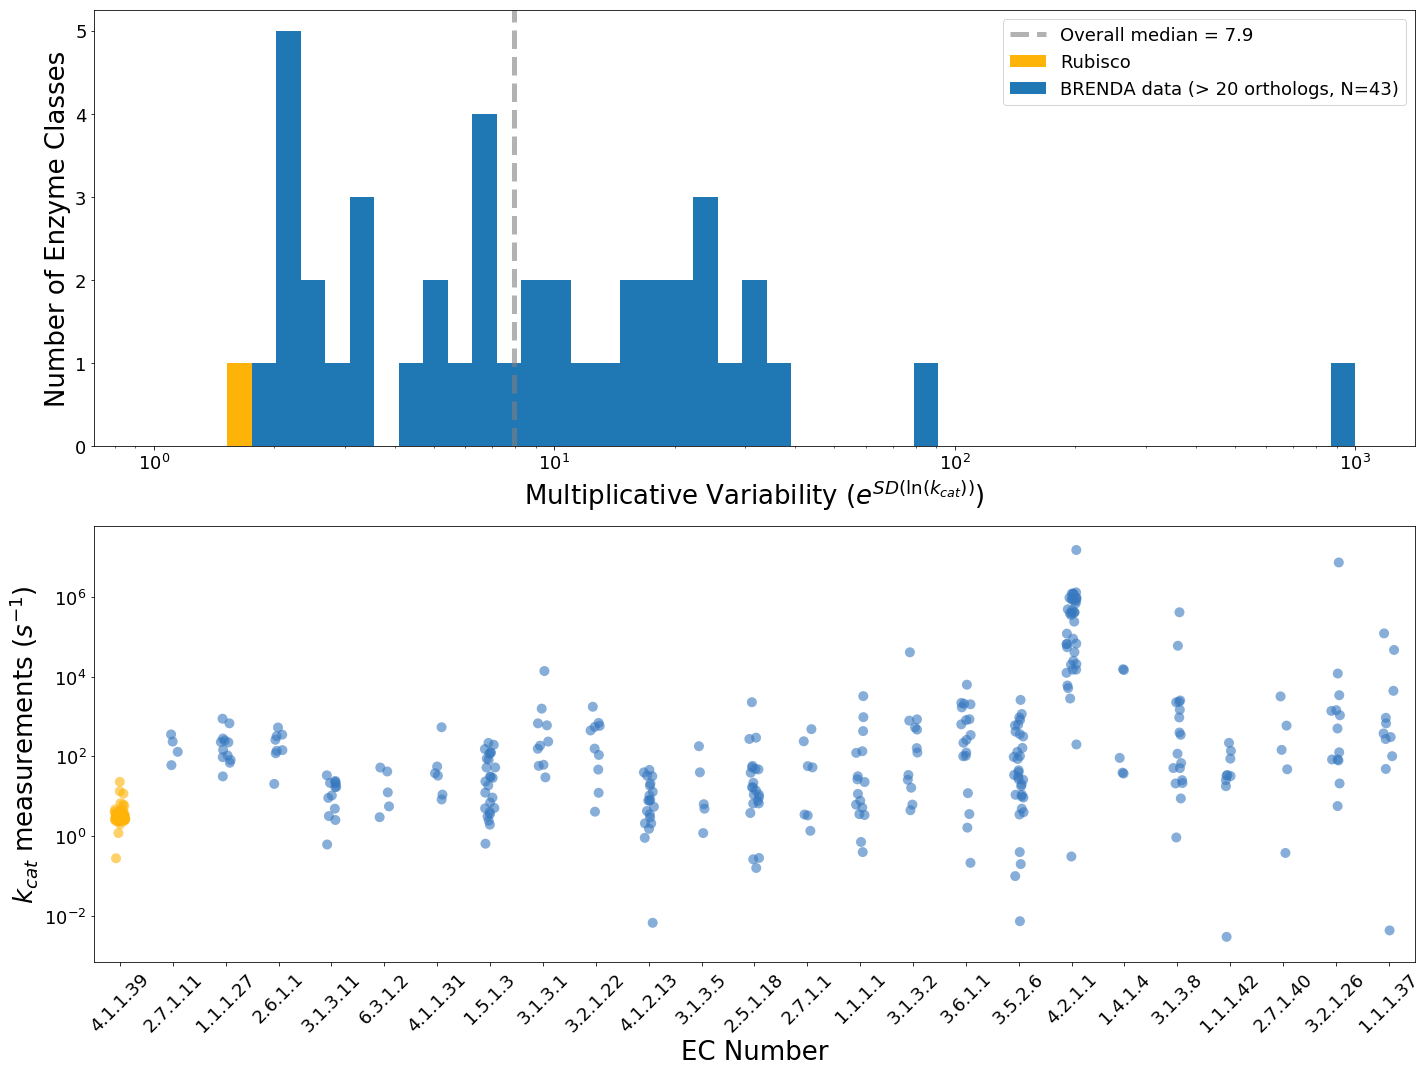

Median multiplicative variability 7.943362237681023


In [7]:
figure = plt.figure(figsize=(20,15))

gs = plt.GridSpec(2, 1)

# Histogram of variabilities
plt.subplot(gs[0])
plt.xscale('log')

bins = np.logspace(0, 3, 50)
enough_reports = var_df[var_df.n_orthologs > 20]
enough_reports_no_rub = enough_reports.drop('4.1.1.39')
plt.hist(enough_reports.mult_var, bins=bins, label='Rubisco', color=named_colors[1])
plt.hist(enough_reports_no_rub.mult_var, bins=bins, label='BRENDA data (> 20 orthologs, N=%d)' % enough_reports.shape[0])
#plt.axvline(rub_mult_var, color=named_colors[1], lw=5, ls='--',
#            label='Rubisco = %.1f' % rub_mult_var, alpha=0.6)
plt.axvline(enough_reports.mult_var.median(), color='grey', lw=5, ls='--',
            label='Overall median = %.1f' % enough_reports.mult_var.median(), alpha=0.6)

plt.legend(loc=1, fontsize=18)
plt.tick_params(labelsize=18)
plt.xlabel('Multiplicative Variability ($e^{SD(\ln(k_{cat}))}$)', fontsize=26)
plt.ylabel('Number of Enzyme Classes', fontsize=26)

# Top 25 ECs by number of orthologs
ax = plt.subplot(gs[1])

plt.yscale('log')
palette = [named_colors[1]] + [named_colors[0]] * 24
sns.stripplot(x='EC_number', y='kcat', order=top_counts.index, data=brenda_kcats_subset,
              jitter=0.1, palette=palette, size=10, alpha=0.6)
plt.xticks(fontsize=18, ha='center', rotation=45)
plt.yticks(fontsize=18)

plt.xlabel('EC Number', fontsize=26)
plt.ylabel('$k_{cat}$ measurements ($s^{-1}$)', fontsize=26)

plt.tight_layout()
plt.show()

print('Median multiplicative variability', enough_reports.mult_var.median())

In [8]:
enough_reports.sort_values('mult_var')

,mult_var,n_orthologs
EC,,
4.1.1.39,1.529829,248
2.7.7.27,2.015980,22
3.2.1.28,2.062320,24
2.7.1.11,2.161522,36
1.2.1.12,2.249762,21
2.7.2.3,2.268182,22
4.1.3.1,2.295567,21
1.1.1.27,2.586473,35
2.7.1.90,2.653781,24
